## Introduction:

This notebook is devoted to predict CLV 

Main reference >> 

https://www.datacamp.com/community/tutorials/customer-life-time-value


Dataset >>

http://archive.ics.uci.edu/ml/datasets/online+retail#

In [154]:
#import modules
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import numpy as np

#split training set and test set
from sklearn.cross_validation import train_test_split


# linear regression model
from sklearn.linear_model import LinearRegression

## model evaluation
from sklearn import metrics

## Read Data:

In [80]:
data = pd.read_excel("Online_Retail.xlsx")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Remove Duplicates:

In [81]:
filtered_data=data[['Country','CustomerID']].drop_duplicates()
filtered_data.head() ## remaining data without duplicates

,Country,CustomerID
0,United Kingdom,17850.0
9,United Kingdom,13047.0
26,France,12583.0
46,United Kingdom,13748.0
65,United Kingdom,15100.0


## Top 10 countries customers:

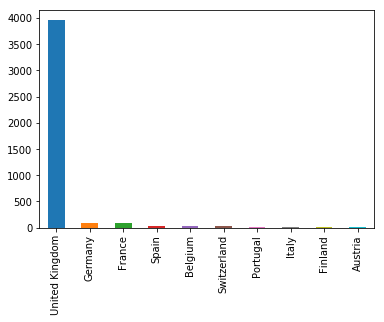

In [82]:
filtered_data.Country.value_counts()[:10].plot(kind = 'bar')

UK has the highest number of customers ..

Hence we can work on those customers only

In [83]:
uk_data = data[data.Country == 'United Kingdom']
uk_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Let's explore uk_data .. 

In [84]:
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      495478 non-null object
StockCode      495478 non-null object
Description    494024 non-null object
Quantity       495478 non-null int64
InvoiceDate    495478 non-null datetime64[ns]
UnitPrice      495478 non-null float64
CustomerID     361878 non-null float64
Country        495478 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 34.0+ MB


In [85]:
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


We have customers with negative price! .. 
let's exclude them!

In [86]:
uk_data = uk_data[(uk_data['UnitPrice']  > 0)]

In [87]:
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,492979.000000,492979.000000,361854.000000
mean,8.924025,4.600276,15547.920194
std,224.836956,97.039127,1594.384238
min,-80995.000000,0.001000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


## Feature Selection:

Here, we need (CustomerID, InvoiceDate, InvoiceNo, Quantity, and UnitPrice) ..

CustomerID helps to uniquely identified the customer 

InvoiceDate, InvoiceNo reflects the rencency, and frequency parts of RFM

Quantity, and UnitPrice help in calculating the monetary part of RFM

In [88]:
uk_data = uk_data[['CustomerID', 'InvoiceDate', 'InvoiceNo', 'Quantity', 'UnitPrice']]

Calculate the total purchases 

In [89]:
uk_data['TotalPurchase'] = uk_data['Quantity']*uk_data['UnitPrice']

Now, RFM will be prepared as follows .. 

R >> Calculate the number of days between the present date and the date of last purchase from each customer.

F >> Calculate the number of orders for each customer.

M >> Calculate sum of purchase price for each customer.

In [90]:
uk_data_group = uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days, 
                                                   'InvoiceNo': lambda num: len(num),
                                                   'Quantity': lambda quant: quant.sum(),
                                                   'TotalPurchase': lambda price: price.sum()})

In [91]:
uk_data_group.head()

,InvoiceDate,InvoiceNo,Quantity,TotalPurchase
CustomerID,,,,
12346.0,0,2,0,0.00
12747.0,366,103,1275,4196.01
12748.0,372,4641,24209,29072.10
12749.0,209,231,1422,3868.20
12820.0,323,59,722,942.34


Let's change the names of the columns to more meaningful ones .. 

In [92]:
uk_data_group.columns = ['num_days','num_transactions','num_units','spent_money']

In [93]:
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money
CustomerID,,,,
12346.0,0,2,0,0.00
12747.0,366,103,1275,4196.01
12748.0,372,4641,24209,29072.10
12749.0,209,231,1422,3868.20
12820.0,323,59,722,942.34


Then, 

CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

Customer Value = Average Order Value * Purchase Frequency

In [94]:
# Average Order Value = spent_money / number of transactions

uk_data_group['avg_order_value'] = uk_data_group['spent_money']/uk_data_group['num_transactions']

In [95]:
## purchase Frequence = total number of transactions/total number of customers

purchase_frequency = sum(uk_data_group['num_transactions'])/uk_data_group.shape[0]
purchase_frequency

91.6318055203849

In [96]:
## claculate churn rate .. that is a function of repeat rate
## churn rate = 1 - repeat purchase rate

repeat_rate = uk_data_group[uk_data_group.num_transactions > 1].shape[0]/uk_data_group.shape[0]
repeat_rate

0.98100785008863

In [97]:
churn_rate = 1 - repeat_rate

let's calculate the parofit margin .. 

In [98]:
uk_data_group['profit_margin'] = uk_data_group['spent_money']*0.05
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin
CustomerID,,,,,,
12346.0,0,2,0,0.00,0.000000,0.0000
12747.0,366,103,1275,4196.01,40.737961,209.8005
12748.0,372,4641,24209,29072.10,6.264189,1453.6050
12749.0,209,231,1422,3868.20,16.745455,193.4100
12820.0,323,59,722,942.34,15.971864,47.1170


In [99]:
## customer value

uk_data_group['customer_value'] = (uk_data_group['avg_order_value']*purchase_frequency)/churn_rate
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,customer_value
CustomerID,,,,,,,
12346.0,0,2,0,0.00,0.000000,0.0000,0.000000
12747.0,366,103,1275,4196.01,40.737961,209.8005,196549.255992
12748.0,372,4641,24209,29072.10,6.264189,1453.6050,30222.956758
12749.0,209,231,1422,3868.20,16.745455,193.4100,80792.129455
12820.0,323,59,722,942.34,15.971864,47.1170,77059.773641


In [100]:
uk_data_group['CLV'] = uk_data_group['customer_value']*uk_data_group['profit_margin']
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,customer_value,CLV
CustomerID,,,,,,,,
12346.0,0,2,0,0.00,0.000000,0.0000,0.000000,0.000000e+00
12747.0,366,103,1275,4196.01,40.737961,209.8005,196549.255992,4.123613e+07
12748.0,372,4641,24209,29072.10,6.264189,1453.6050,30222.956758,4.393224e+07
12749.0,209,231,1422,3868.20,16.745455,193.4100,80792.129455,1.562601e+07
12820.0,323,59,722,942.34,15.971864,47.1170,77059.773641,3.630825e+06


Now, we calculated CLV to the existing customers .. meanwhile, what if we want to calculate CLV to the potential customers or future customers?!

this is why we gonna build a prediction model that help in predict CLV .. 

for simplicity we gonna make it using linear regression model .. 


back to the original data, we gonna extract month and year of each transaction ..

In [101]:
uk_data['month_year'] = uk_data['InvoiceDate'].apply(lambda x:x.strftime('%b-%Y'))

In [102]:
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPurchase,month_year
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30,Dec-2010
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00,Dec-2010
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010


let's create pivot table from the month, year and customer_ID .. 

to track the sales every month .. 

In [103]:
sales = uk_data.pivot_table(index = ['CustomerID'], columns = ['month_year'], values = ['TotalPurchase'], aggfunc = 'sum', fill_value = 0).reset_index()

In [104]:
sales.head()

CustomerID TotalPurchase                                      \
month_year                 Apr-2011 Aug-2011 Dec-2010 Dec-2011 Feb-2011   
0             12346.0          0.00     0.00     0.00     0.00     0.00   
1             12747.0          0.00   301.70   706.27   438.50     0.00   
2             12748.0       1100.37   659.42  4177.68  1070.27   389.64   
3             12749.0          0.00  1750.45     0.00   763.06     0.00   
4             12820.0          0.00     0.00     0.00   210.35     0.00   

                                                                           \
month_year Jan-2011 Jul-2011 Jun-2011 Mar-2011 May-2011 Nov-2011 Oct-2011   
0              0.00     0.00     0.00     0.00     0.00     0.00     0.00   
1            303.04     0.00   376.30   310.78   771.31   312.73   675.38   
2            418.77  1113.27  2006.26  1011.94  2224.42  9295.57  1385.84   
3              0.00     0.00     0.00     0.00   782.10   572.59     0.00   
4            170.46     0.00     0.00     0.00     0.00     0.00   343.76   

                     
month_year Sep-2011  
0              0.00  
1              0.00  
2           4218.65  
3              0.00  
4            217.77

Let's calculate CLV for each month .. 

In [105]:
sales['CLV'] = sales.iloc[:, 2:].sum(axis = 1)

In [106]:
sales.head()

CustomerID TotalPurchase                                      \
month_year                 Apr-2011 Aug-2011 Dec-2010 Dec-2011 Feb-2011   
0             12346.0          0.00     0.00     0.00     0.00     0.00   
1             12747.0          0.00   301.70   706.27   438.50     0.00   
2             12748.0       1100.37   659.42  4177.68  1070.27   389.64   
3             12749.0          0.00  1750.45     0.00   763.06     0.00   
4             12820.0          0.00     0.00     0.00   210.35     0.00   

                                                                           \
month_year Jan-2011 Jul-2011 Jun-2011 Mar-2011 May-2011 Nov-2011 Oct-2011   
0              0.00     0.00     0.00     0.00     0.00     0.00     0.00   
1            303.04     0.00   376.30   310.78   771.31   312.73   675.38   
2            418.77  1113.27  2006.26  1011.94  2224.42  9295.57  1385.84   
3              0.00     0.00     0.00     0.00   782.10   572.59     0.00   
4            170.46     0.00     0.00     0.00     0.00     0.00   343.76   

                          CLV  
month_year Sep-2011            
0              0.00      0.00  
1              0.00   4196.01  
2           4218.65  27971.73  
3              0.00   3868.20  
4            217.77    942.34

In the linear regression model that we gonna build we can depend on the last 6 months only, and assume that these are its independent and CLV are their dependent .. 

In [135]:
X = sales.iloc[:,8:14]
X.head()

TotalPurchase                                             
month_year      Jun-2011 Mar-2011 May-2011 Nov-2011 Oct-2011 Sep-2011
0                   0.00     0.00     0.00     0.00     0.00     0.00
1                 376.30   310.78   771.31   312.73   675.38     0.00
2                2006.26  1011.94  2224.42  9295.57  1385.84  4218.65
3                   0.00     0.00   782.10   572.59     0.00     0.00
4                   0.00     0.00     0.00     0.00   343.76   217.77

In [139]:
y=sales[['CLV']]

In [140]:
y.head()

,CLV
month_year,
0,0.00
1,4196.01
2,27971.73
3,3868.20
4,942.34


## Train test split 

Let's split the data to train and test .. 

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

## Model Prediction

In [146]:
linreg = LinearRegression()
linreg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [148]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [149]:
y_pred = linreg.predict(X_test) ## this carries the predicted values 

In [153]:
## let's print the model coefficients 

linreg.intercept_, linreg.coef_

(array([30.33695322]),
 array([[1.66431758, 2.40161213, 1.68124232, 1.38269254, 1.47446094,
         1.37012707]]))

## Model Evaluation:

In [155]:
## R_square

metrics.r2_score(y_test, y_pred)

0.975515121850137

Wow!

The R square of the model exceeds 97% .. whiche means that 97% of the dependent variable is justified using the indepedent variables i.e. those variables are perfictly describe the dependent variables 